In [27]:
import pandas as pd
import numpy as np
import os
import os.path as op
import torch.nn as nn
from functools import partial

IMAGE_WIDTH = {5: 15, 20: 60, 60: 180}
IMAGE_HEIGHT = {5: 32, 20: 64, 60: 96}  

# Construct CNN

In [28]:
class CNN(nn.Module):

    def __init__(self, 
                 num_class=2,       
                 initial_filter = 64,
                 filter_sizes= (5,3),
                 maxpool_sizes= (2,1),
                 dilation=(2,1),
                 stride=(2,1),
                 p=0.5,
                 BN=True,
                 Activation='LRELU'
                ):
        
        super(CNN, self).__init__()
        
        padding = (
            (filter_sizes[0]-1)//2,
            (filter_sizes[1]-1)//2
       )
        
        #BOOLEAN:whether to use batch norm
        self.BN = BN
        #STRING: type of activation
        self.Activation = Activation
        # int : 2 for binary
        self.num_class = num_class
        # float: prob for dropout
        self.p = p
        
        if self.Activation=='LRELU':
            self.lrelu = nn.LeakyReLU(negative_slope=0.01, inplace=True)
        else:
            self.lrelu = nn.ReLU(inplace=True)
            
        
        self.conv1 = nn.Conv2d(in_channels=1, 
                      out_channels=initial_filter, 
                      kernel_size=filter_sizes,
                      padding=padding,
                      stride=stride, 
                      dilation=dilation)
        
        self.bn1 = nn.BatchNorm2d(initial_filter)
        self.pool1 = nn.MaxPool2d(kernel_size=maxpool_sizes, 
                                       stride=maxpool_sizes)
            
            
        self.conv2= nn.Conv2d(
                      in_channels=initial_filter, 
                      out_channels=initial_filter*2, 
                      kernel_size=filter_sizes,
                      padding=padding
                      )
        
        self.bn2 = nn.BatchNorm2d(initial_filter*2)
        self.pool2 = nn.MaxPool2d(kernel_size=maxpool_sizes, 
                                  stride=maxpool_sizes)
            
        self.conv3 = nn.Conv2d(in_channels=initial_filter*2, 
                      out_channels=initial_filter*4, 
                      kernel_size=filter_sizes,
                      padding=padding
                      )
                        
        self.bn3=nn.BatchNorm2d(initial_filter*4)
        self.pool3 = nn.MaxPool2d(kernel_size=maxpool_sizes, 
                                  stride=maxpool_sizes)
        
        
        #no need for softmax
        #self.classifier = nn.Softmax(dim=1) #dim=1        
        
        self.fc = nn.Linear(46080, self.num_class)
        
        self.dropout = nn.Dropout(p=self.p)
        
        #XAVIER initialization
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.xavier_uniform_(self.conv3.weight)
        nn.init.xavier_uniform_(self.fc.weight)

    
    def forward(self, x):
        #print('Block1')
        x = self.conv1(x)
        #print(x.shape)
        if self.BN:
            x = self.bn1(x)
        x = self.lrelu(x)
        x = self.pool1(x)
        #print(x.shape)

        #print('Block2')
        x = self.conv2(x)
        #print(x.shape)
        if self.BN:
            x = self.bn2(x)
        x = self.lrelu(x)
        x = self.pool2(x)
        #print(x.shape)
        
        #print('Block3')
        x = self.conv3(x)
        #print(x.shape)
        if self.BN:
            x = self.bn3(x)
        x = self.lrelu(x)
        x = self.pool3(x)
        #print(x.shape)
        
        
        
        x = x.view(x.size(0), -1)
        #print('Flatten-FC')
        #print(x.shape)
        
        x = self.dropout(x)
        #drop out applied to Linear layer. 
        #print('after drop out')
        #print(x.shape)
        x = self.fc(x)
        #x=self.dropout(self.fc(x))        
        
        #softmax is not needed for our loss function
        #print('after linear layer')
        #print(x.shape)
        #x = self.classifier(x)  #take a vector z [2,1] -> probabilityfloat

In [29]:
# Assume that we are on a CUDA machine, then this should print a CUDA device:
import os
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

use_gpu = torch.cuda.is_available()



# Training hyperparameters

In [30]:
target_label ='Ret_20d' 

lr = 1e-5 
BATCH_SIZE = {'train':128,
              'test':128}
momentum = 0.9
num_epochs = 50
#Patience of early stopping
patience = 2
     
#pin_memory ensures movement of data from cpu to gpu is efficient and fast. 
#In case one uses inbuilt datasets like MNIST or CIFAR10 then this parameter is not required as in that case data is loaded directly into GPU. 
#num_workers attribute tells the data loader instance how many sub-processes to use for data loading
pin_memory = True
num_workers = 2



# Load Data

In [31]:
Label_Raw=pd.read_hdf('./Label_Train.h5',key='data')
length_Train=pd.read_hdf('./length_Train.h5',key='data')

#Now all images are saved in 1993 file
year = 1993
Images = np.memmap(
            op.join("./img_data/monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_images.dat"), 
            dtype=np.uint8, mode='r+').reshape(
                                        (-1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20]))
        
Label_Raw = Label_Raw.reset_index().drop('index',axis=1) 

In [32]:
len(Images)

694871

In [33]:
#Convert into labels:
# 1: positive return
# 0: negative returns
raw_labels = np.sign(
    Label_Raw[target_label].mask(Label_Raw[target_label]==0).dropna()
    )
raw_labels[raw_labels<0] = 0
classes = raw_labels.unique()
classes

#adjust format for dataloader below
annotations = raw_labels.reset_index().rename(columns= {'index':'img_name',
                                           target_label:'label'})


In [34]:
import random
random.seed(10)

In [35]:
#Use Pytorch's DataLoader

In [43]:
from torch.utils.data import Dataset
import pandas as pd
import os
from PIL import Image
import torch

class CNNDataset(Dataset):
    def __init__(self, Images_map ,annotations, transform=None):
        
        self.annotations = annotations
        self.transform = transform
        self.Images = Images_map

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        
        img_id = self.annotations.iloc[index, 0]
        img = torch.from_numpy(self.Images[[img_id]]).type(torch.float)        
        y_label = torch.tensor((self.annotations.iloc[index, 1])).type(torch.long)

        if self.transform is not None:
            img = self.transform(img)

        return (img, y_label)

In [44]:
from torch.utils.data import DataLoader


train_size = int(len(annotations) * 0.7)
val_size = len(annotations) - train_size
#create dataset object
dataset = CNNDataset(Images,annotations)

#split train vs validation
train_set, validation_set = torch.utils.data.random_split(dataset,[train_size,val_size])

trainloader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE['train'],shuffle=True,
                          num_workers=num_workers,pin_memory=pin_memory)
valloader = DataLoader(dataset=validation_set, batch_size=BATCH_SIZE['test'],shuffle=False,
                               num_workers=num_workers, pin_memory=pin_memory) 

loaders = {'train': trainloader, 'test': valloader}

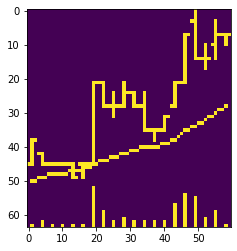

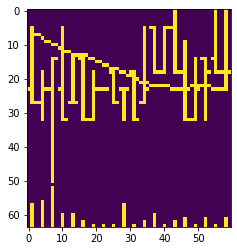

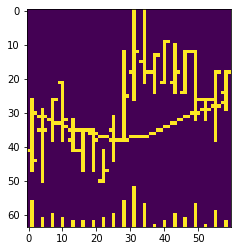

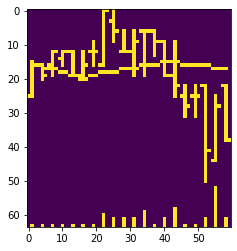

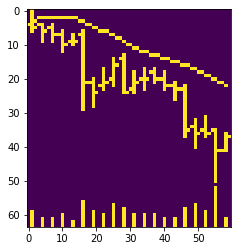

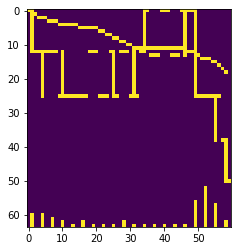

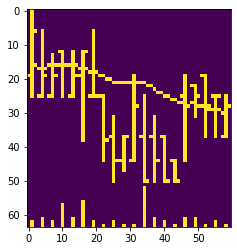

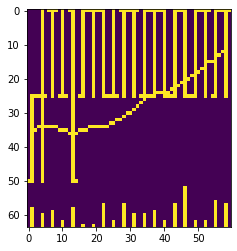

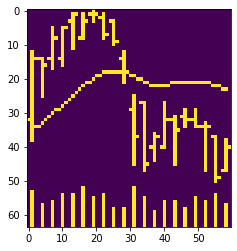

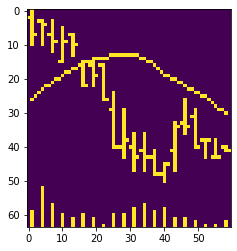

In [45]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

from matplotlib.pyplot import imshow
from matplotlib.pyplot import show
for img in images[:10]:
    imshow(img[0])
    show()

# Training

In [46]:
import os
import re
import time
import scipy.stats

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res



In [47]:
# Train the model
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
#optimizer = optim.Adam(model.parameters(), lr=lr)  #Adam



In [48]:

'''
def train_model(model, criterion, optimizer, log_saver, num_epochs=100):

    
    
    torch.manual_seed(seed)
    

    return model, log_saver

model, log = train_model(
    model, criterion, optimizer, log, num_epochs=num_epochs)
    
'''

'\ndef train_model(model, criterion, optimizer, log_saver, num_epochs=100):\n\n    \n    \n    torch.manual_seed(seed)\n    \n\n    return model, log_saver\n\nmodel, log = train_model(\n    model, criterion, optimizer, log, num_epochs=num_epochs)\n    \n'

In [49]:
for seed in range(0,5):
    # The log for recording train (test) loss and errors.
    log = {
        'num_params': [],
        'train_loss': [],
        'train_error': [],
        'test_loss': [],
        'test_error': []
    }
    log_saver = log 
    num_epochs = 50


    print('seed '+str(seed))
    torch.manual_seed(seed)
    
    
    
    ##############################################################
    #create a model
    #changing parameters if needed
    model = CNN()
    #changing the model_name. this will save the output to new path
    model_name ='Baseline_GPU'
    ##############################################################
    
    
    if use_gpu:
        print('GPU')
        device = torch.device("cuda:2" if use_gpu else "cpu")
        model = model.cuda()
    
    name = model_name+'_'+str(seed)
    
    since = time.time()
    steps = 0
    last_loss = 100
    triggertimes = 0




    #optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    optimizer = optim.Adam(model.parameters(), lr=lr)  #Adam
    number_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    log['num_params'].append(number_params)

    print(f'total parameters: {number_params}')    

    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        
        for phase in ['train', 'test']:
                        
            loss_meter = AverageMeter()
            acc_meter = AverageMeter()
            margin_error_meter = AverageMeter()

            if phase == 'train':
                model.train(True)
            else:
                model.train(False)
            
                        
            for i, data in enumerate(loaders[re.findall('[a-zA-Z]+',phase)[0]]):
                inputs, labels = data
                
                normalize = True
                if normalize:
                    inputs /=255
                
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                optimizer.zero_grad()

                outputs = model(inputs) 
                
                #if steps <1000 and steps % 10 ==0 :
                #    display(outputs)

                _, preds = torch.max(outputs.data, 1)
                    
                    
                loss = criterion(outputs, 
                    labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    steps += 1

                N = outputs.size(0)

                loss_meter.update(loss.data.item(), N)
                acc_meter.update(
                    accuracy(outputs.data, labels.data)[-1].item(), N)
                        
            epoch_loss = loss_meter.avg
            epoch_error = 1 - acc_meter.avg / 100
            if phase == 'train':
                log_saver['train_loss'].append(epoch_loss)
                log_saver['train_error'].append(epoch_error)

            elif phase == 'test':

                log_saver['test_loss'].append(epoch_loss)
                log_saver['test_error'].append(epoch_error)

#            if phase != 'train':
            print(
                    f'{phase} loss: {epoch_loss:.4f}; error: {epoch_error:.4f}'
            )
            print(i)
            
                    
        if epoch % 100 == 0 or epoch == num_epochs - 1:
            print('Saving..')
            state = {'net': model, 'epoch': epoch, 'log': log_saver}

            if not os.path.isdir('./checkpoint_CNN/'+model_name):
                os.makedirs('./checkpoint_CNN/'+model_name)
            torch.save(state,
                       './checkpoint_CNN/'+model_name+'/'+name+'.t7')
            
        #Early Stopping            
        print('Cycle Completed for: '+phase+', total samples '+str(loss_meter.count))
        current_loss = epoch_loss
        if current_loss >= last_loss:
            trigger_times += 1
            print('Trigger Times:', trigger_times)
            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                break
                #return model, log_saver
        else:
            print('trigger times: 0')
            trigger_times = 0
        last_loss = current_loss
                    
            

    time_elapsed = time.time() - since
    print(
        f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s'
    )
    
    #save final model:
    state = {'net': model, 'epoch': epoch, 'log': log_saver}
    torch.save(state,
               './checkpoint_CNN/'+model_name+'/'+name+'_final.t7')


seed 0
GPU
total parameters: 708866
Epoch 1/50
----------
train loss: 0.9515; error: 0.4951
3768
test loss: 0.7095; error: 0.4834
1615
Saving..
Cycle Completed for: test, total samples 206754
trigger times: 0
Epoch 2/50
----------
train loss: 0.7989; error: 0.4893
3768
test loss: 0.6999; error: 0.4798
1615
Cycle Completed for: test, total samples 206754
trigger times: 0
Epoch 3/50
----------
train loss: 0.7418; error: 0.4846
3768
test loss: 0.6932; error: 0.4738
1615
Cycle Completed for: test, total samples 206754
trigger times: 0
Epoch 4/50
----------
train loss: 0.7145; error: 0.4787
3768
test loss: 0.6909; error: 0.4698
1615
Cycle Completed for: test, total samples 206754
trigger times: 0
Epoch 5/50
----------
train loss: 0.7005; error: 0.4700
3768
test loss: 0.6900; error: 0.4666
1615
Cycle Completed for: test, total samples 206754
trigger times: 0
Epoch 6/50
----------
train loss: 0.6928; error: 0.4626
3768
test loss: 0.6924; error: 0.4719
1615
Cycle Completed for: test, total sam

In [50]:
#136min36.8s

# Plot the results (for the last model in the loop):

In [51]:

import matplotlib.pyplot as plt
import numpy as np
def plot(log, result_dir):
    fontdict = {'size': 30}

    def get_fig(i, title):
        fig = plt.figure(i, figsize=(20, 10))
        ax = fig.add_subplot(111)
        #plt.title(title, fontsize=30, y=1.04)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        return fig, ax

    fig1, ax1 = get_fig(1, 'Loss on Cifar10')
    fig2, ax2 = get_fig(2, 'Error on Cifar10')

    ax1.plot(log['train_loss'],'b', linewidth=3, label='training')
    ax1.plot(log['test_loss'],'r', linewidth=3, label='test')
    ax1.set_ylabel('loss',fontdict=fontdict)
    ax2.plot(log['train_error'],'b', linewidth=3, label='training')
    ax2.plot(log['test_error'],'r', linewidth=3, label='test')
    ax2.set_ylabel('error',fontdict=fontdict)

    for ax in [ax1, ax2]:
        ax.set_xlabel('Number of epochs', fontdict=fontdict)
        ax.legend(loc='upper right', fontsize=20)
        
    if not os.path.exists(result_dir):
        os.mkdir(result_dir)
    fig1.savefig(result_dir + 'loss.png')
    fig2.savefig(result_dir + 'error.png')


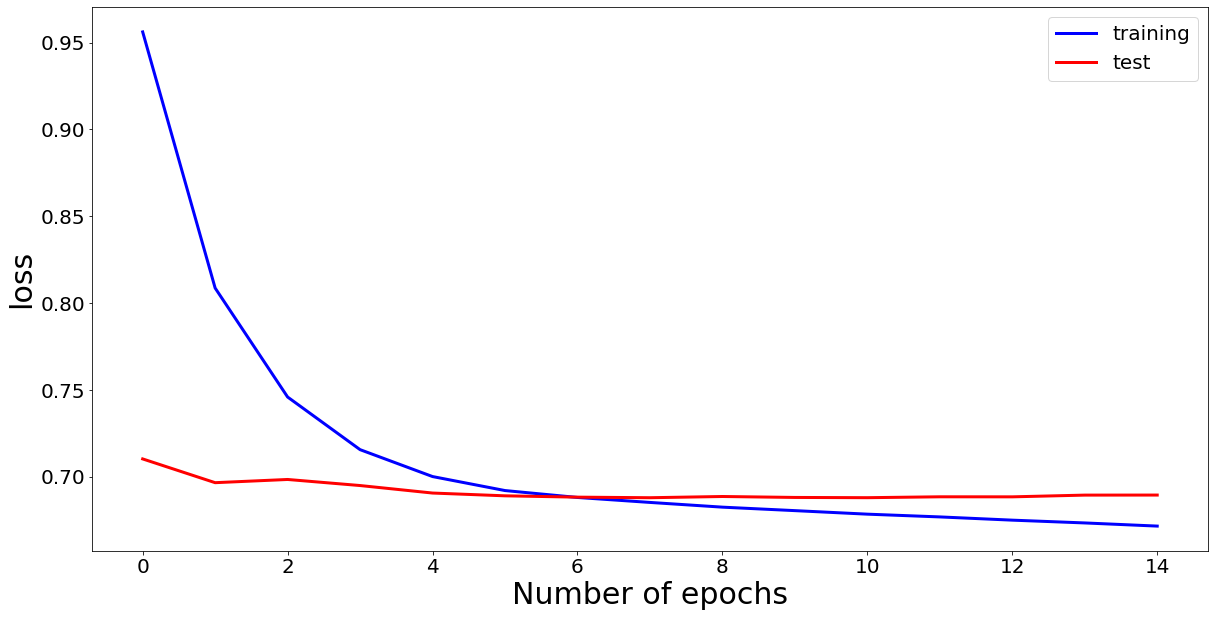

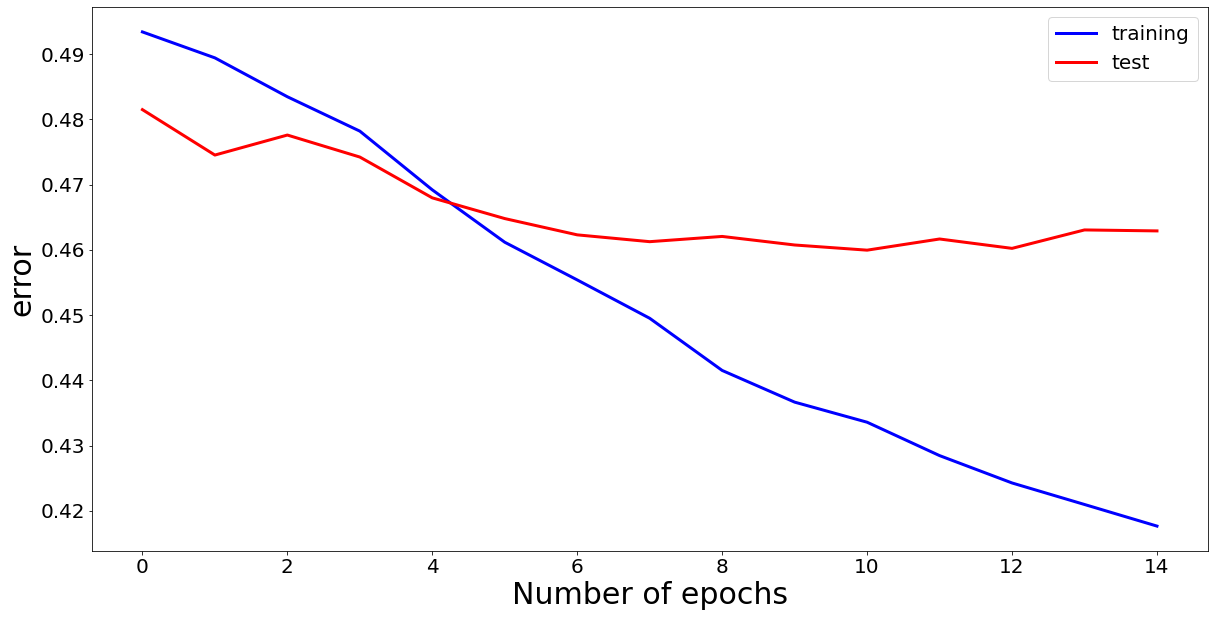

In [52]:
plot(log, './alex_results/')
plt.show()

# Evaluating the results

# Load Test Data

In [53]:
Label_Test=pd.read_hdf('./Label_Test.h5',index_col=[0])
length_Test=pd.read_hdf('./length_Test.h5',key='data')   

year = 2000
Images_Test = np.memmap(
                    op.join("./img_data/monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_images.dat"), 
                    dtype=np.uint8, mode='r+',order='C',
                    shape=(len(Label_Test), IMAGE_HEIGHT[20], IMAGE_WIDTH[20]))
Label_Test = Label_Test.reset_index().drop('index',axis=1) 
Label_Test.tail()

,Date,StockID,EWMA_vol,Retx,Retx_5d,Retx_20d,Retx_60d,Retx_week,Retx_month,Retx_quarter,...,Ret_week,Ret_month,Ret_quarter,Ret_5d,Ret_20d,Ret_60d,Ret_65d,Ret_180d,Ret_250d,Ret_260d
1502118,2019-08-30,93436,0.000867,0.017591,0.027392,0.067639,0.490805,0.008156,0.067639,NaN,...,0.008156,0.067639,NaN,0.027392,0.067639,0.490805,0.490184,2.581457,8.923116,7.260295
1502119,2019-09-30,93436,0.000920,-0.005204,-0.013078,0.360527,0.765477,NaN,0.307429,0.736748,...,NaN,0.307429,0.736748,-0.013078,0.360527,0.765477,0.786276,3.117543,7.455629,8.009052
1502120,2019-10-31,93436,0.002130,-0.000286,0.065478,0.047695,0.844879,NaN,0.047695,NaN,...,NaN,0.047695,NaN,0.065478,0.047695,0.844879,1.332972,3.980189,5.446411,5.622802
1502121,2019-11-29,93436,0.001075,-0.004075,0.018034,0.256895,1.057951,0.018034,0.267897,NaN,...,0.018034,0.267897,NaN,0.018034,0.256895,1.057951,1.195976,4.719502,7.698562,NaN
1502122,2019-12-31,93436,0.000757,0.008753,0.176440,0.531828,0.229557,NaN,0.555159,0.252601,...,NaN,NaN,NaN,0.176440,0.531828,0.229557,0.147444,4.060971,NaN,NaN


In [54]:
Label_Test.shape

(1502123, 35)

In [55]:
Images_Test.shape

(1502123, 64, 60)

In [56]:
raw_labels = np.sign(
    Label_Test[target_label].mask(Label_Test[target_label]==0).dropna()
    )
raw_labels[raw_labels<0] = 0
classes = raw_labels.unique()


annotations_test = raw_labels.reset_index().rename(columns= {'index':'img_name',
                                           target_label:'label'})
annotations_test

,img_name,label
0,0,1.0
1,1,0.0
2,2,1.0
3,3,0.0
4,4,0.0
...,...,...
1490883,1502118,1.0
1490884,1502119,1.0
1490885,1502120,1.0
1490886,1502121,1.0


In [57]:
#Load dataset
from torch.utils.data import DataLoader


dataset_test = CNNDataset(Images_Test,annotations_test)


testloader = DataLoader(dataset=dataset_test, 
                        batch_size=BATCH_SIZE['test'],
                        shuffle=False,
                        num_workers=num_workers, pin_memory=pin_memory) 



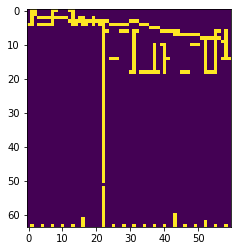

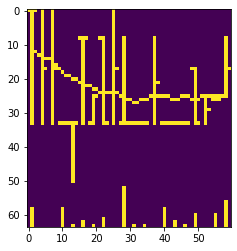

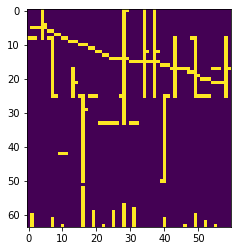

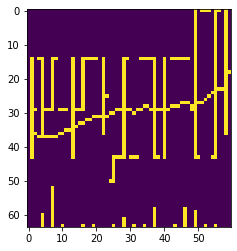

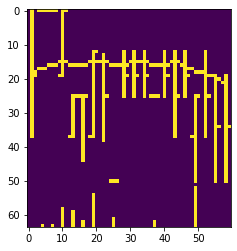

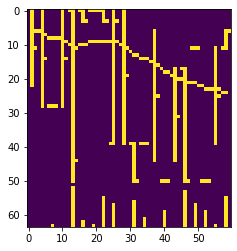

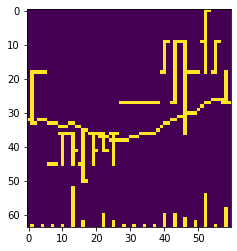

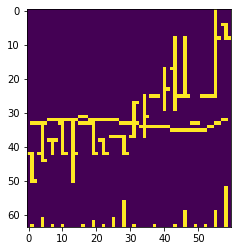

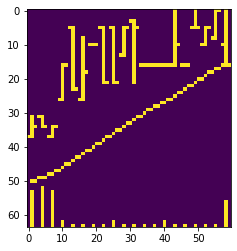

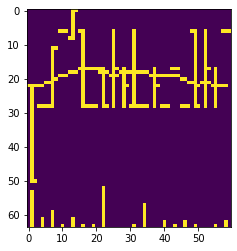

In [58]:
dataiter = iter(testloader)
images, labels = dataiter.next()

from matplotlib.pyplot import imshow
from matplotlib.pyplot import show
for img in images[:10]:
    imshow(img[0])
    show()

# Generate Predictions

In [62]:
import torch
epoch_loss = pd.Series()
epoch_accuracy = pd.Series()
PREDICTIONS = {}
# The log for recording train (test) loss and errors.
criterion = nn.CrossEntropyLoss()
Predictions = []

for seed in range(0,5):
    Predictions = []
    print('seed '+str(seed))
    torch.manual_seed(seed)
    name = model_name+'_'+str(seed)
    
    state = torch.load(
        './checkpoint_CNN/'+model_name+'/'+name+'_final.t7')
                    

    model = state['net']

    number_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'total parameters: {number_params}')

    if use_gpu:
        model = model.cuda()

    since = time.time()
    steps = 0

    loss_meter = AverageMeter()
    acc_meter = AverageMeter()
    margin_error_meter = AverageMeter()

    model.eval()


    for i, data in enumerate(testloader):
        inputs, labels = data

        normalize = True
        if normalize:
            inputs /=255

        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = model(inputs) 

        _, preds = torch.max(outputs.data, 1)

        prob = torch.Tensor.numpy(torch.nn.functional.softmax(
            outputs.data.cpu()
            ,dim=1)[:,1])
        
        prob = list(prob)

        Predictions += prob

        loss = criterion(outputs, 
            labels)

        N = outputs.size(0)

        loss_meter.update(loss.data.item(), N)
        acc_meter.update(
            accuracy(outputs.data, labels.data)[-1].item(), N)

    epoch_loss.loc[seed] = loss_meter.avg
    epoch_accuracy.loc[seed] = acc_meter.avg 
    PREDICTIONS[seed] = pd.Series(Predictions)


seed 0
total parameters: 708866


/tmp/ipykernel_7838/448111148.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  epoch_loss = pd.Series()
/tmp/ipykernel_7838/448111148.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  epoch_accuracy = pd.Series()


seed 1
total parameters: 708866
seed 2
total parameters: 708866
seed 3
total parameters: 708866
seed 4
total parameters: 708866


In [79]:
#averaging all results
Predictions = pd.concat(PREDICTIONS,axis=1)
Predictions['mean'] = Predictions.mean(axis=1)

In [80]:
#check
assert len(Predictions) == len(annotations_test), "Unequal dimensions"

In [81]:
Predictions.index = annotations_test.index

annotations_test['prediction'] = Predictions['mean']
Label_Test['prediction']=annotations_test.set_index('img_name')['prediction']
Label_Test['prediction'].count()

1490888

In [83]:
#Store results

if not os.path.isdir('./output_summary/'):
    os.mkdir('./output_summary/')

try:
    Summary=pd.read_hdf('./output_summary/Test Results.h5',key='df')
except:
    Summary = pd.DataFrame(columns=['test loss','test accuracy'])

    
test_results = pd.Series({
            'test loss':epoch_loss.mean(),
            'test accuracy':epoch_accuracy.mean()})
Summary.loc[model_name] = test_results
Summary.to_hdf('./output_summary/Test Results.h5',key='df')


test_results.to_hdf('./output_summary/Test Results.h5',key=model_name)
epoch_loss.to_hdf('./output_summary/epoch_loss.h5',key=model_name)
epoch_accuracy.to_hdf('./output_summary/epoch_accuracy.h5',key=model_name)
Predictions.to_hdf('./output_summary/Predictions by seed.h5',key=model_name)
Label_Test.to_hdf('./output_summary/Predictions.h5',key=model_name)

/tmp/ipykernel_7838/1286646987.py:22: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0] [items->None]

  Predictions.to_hdf('./output_summary/Predictions by seed.h5',key=model_name)
/tmp/ipykernel_7838/1286646987.py:22: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_items] [items->None]

  Predictions.to_hdf('./output_summary/Predictions by seed.h5',key=model_name)


In [84]:
Label_Test=pd.read_hdf('./output_summary/Predictions.h5',key=model_name)

# Portfolio Construction

In [85]:
pred_field = 'prediction'
return_field = 'Ret_month'

In [86]:
y_pred = Label_Test.set_index(['Date','StockID'])[pred_field].unstack()
return_next_per = Label_Test.set_index(['Date','StockID'])[return_field].unstack()
marketcap = Label_Test.set_index(['Date','StockID'])['MarketCap'].unstack()
vol = Label_Test.set_index(['Date','StockID'])['EWMA_vol'].unstack()

In [87]:
#split stocks on each date into deciles
y_rank = y_pred.rank(axis=1)
y_count = y_rank.max(axis=1)
y_normalize = y_rank.div(y_count,axis=0).sub(0.1/y_count,axis=0) * 10
decile_portfolio = np.floor(y_normalize)

In [88]:
Portfolio_Returns = {}
EW = {}
VW = {}

#portfolio weights
EW_w = {} #equally weighted portfolio
VW_w = {} # value (market capitalization) weighted portfolios

Count = {}
for i in range(0,10):
        port = (decile_portfolio==i)
        
        #equal weight
        EW[i+1]=return_next_per.where(port).mean(axis=1)
        
        if i in [0,9]:
            EW_w[i+1]=((port * 1).div(port.sum(axis=1),axis=0)).fillna(0)
        
        #total number of stocks 
        Count[i] = port.sum(axis=1)
        
        #market cap weight
        marketcap_port = marketcap.where(port)
        marketcap_port = marketcap_port.div(marketcap_port.sum(axis=1),axis=0)
        
        VW[i+1] = (marketcap_port * return_next_per).sum(axis=1)
        if i in [0,9]:
            VW_w[i+1]=marketcap_port.fillna(0)
            
#portfolio weights
EW_w = EW_w[10] - EW_w[1]
VW_w = VW_w[10] - VW_w[1]

In [89]:
#Vol Scaled Portfolio
# this is an experiment: no need to report it 
# since different stocks have different volatilities,
# we would like to hold less of a stock if it is more volatile


#demean s.t scores [-0.5,+0.5]
y_vol_scale = (y_normalize/10 - 0.5)
#adjust the volatility
y_vol_scale = y_vol_scale/vol
#adjust to have same leverage
mult = (EW_w.abs() ).sum(axis=1) / (y_vol_scale.abs() ).sum(axis=1)
W_vol_scale  = y_vol_scale.mul(mult,axis=0)

In [90]:

Port_vol_scale = (W_vol_scale * return_next_per).sum(axis=1)

Portfolio_Returns['EW'] = EW
Portfolio_Returns['VW'] = VW
Portfolio_Returns['Vol Controlled'] = Port_vol_scale

In [91]:
pd.concat(
    Portfolio_Returns['EW'],axis=1).to_hdf('./output_summary/Portfolio_Returns_EW.h5',key=model_name)
pd.concat(
    Portfolio_Returns['VW'],axis=1).to_hdf('./output_summary/Portfolio_Returns_VW.h5',key=model_name)
Portfolio_Returns['Vol Controlled'].to_hdf('./output_summary/Portfolio_Returns_Vol Controlled.h5',key=model_name)

EW_w.to_hdf('./output_summary/Equal_Weight_Portfolio.h5',key=model_name)

VW_w.to_hdf('./output_summary/Value_Weight_Portfolio.h5',key=model_name)

In [92]:
# Compute Performance of This Single Strategy 

In [93]:
from scipy.stats import t


def alpha_t(HL):
    t_stat = HL.mean()/(
        HL.std()/np.sqrt(len(HL)))
    return 1 - t.cdf(t_stat, len(HL)-1)

In [94]:
rejection = pd.Series()


ret = pd.concat(Portfolio_Returns['EW'],axis=1)
HL = ret[10] - ret[1]
Dec = pd.concat({
    'Ret':ret.mean()*12,
    'SR':ret.mean()/ret.std()*(12**0.5)
},axis=1)

Dec.loc['H-L'] = pd.Series({
    'Ret':(HL).mean()*12,
    'SR': (HL).mean()/ (HL).std()*(12**0.5)
})

rejection.loc['Equal-Weight'] = alpha_t(HL)
#Turnover
portfolio_beginning = EW_w.shift() * (1+return_next_per.shift())
scaling_factor = (EW_w.shift() * return_next_per.shift()).sum(axis=1)+1
portfolio_beginning = portfolio_beginning.div(scaling_factor,axis=0)
TO = EW_w -  portfolio_beginning
TO = TO.abs().sum(axis=1).mean()/2



ret = pd.concat(Portfolio_Returns['VW'],axis=1)
HL = ret[10] - ret[1]
Dec2 = pd.concat({
    'Ret':ret.mean()*12,
    'SR':ret.mean()/ret.std()*(12**0.5)
},axis=1)

Dec2.loc['H-L'] = pd.Series({
    'Ret':(HL).mean()*12,
    'SR': (HL).mean()/ (HL).std()*(12**0.5)
})
rejection.loc['Value-Weight'] = alpha_t(HL)

#Turnover
portfolio_beginning = VW_w.shift() * (1+return_next_per.shift())
scaling_factor = (VW_w.shift() * return_next_per.shift()).sum(axis=1)+1
portfolio_beginning = portfolio_beginning.div(scaling_factor,axis=0)
TO2 = VW_w -  portfolio_beginning
TO2 = TO2.abs().sum(axis=1).mean()/2

pd.concat({'Equal-Weight':Dec,
          'Value-weight':Dec2},
          axis=1).to_hdf('./output_summary/Portfolio Stats.h5',key=model_name)


/tmp/ipykernel_7838/758093886.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  rejection = pd.Series()
/tmp/ipykernel_7838/758093886.py:46: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis1] [items->None]

  pd.concat({'Equal-Weight':Dec,


In [95]:
#significance
rejection.to_hdf('./output_summary/rejection.h5',key=model_name)

In [96]:
#turnover 
portfolio_beginning = W_vol_scale.shift() * (1+return_next_per.shift())
scaling_factor = (W_vol_scale.shift() * return_next_per.shift()).sum(axis=1)+1
portfolio_beginning = portfolio_beginning.div(scaling_factor,axis=0)

TO3 = W_vol_scale -  portfolio_beginning
TO3 = TO3.abs().sum(axis=1).mean()/2

pd.Series({'Equal-Weight':TO,
          'Value-weight':TO2,
          'Vol-Scale':TO3,
          }).to_hdf('./output_summary/Turnover.h5',key=model_name)

In [97]:
# Factor Loading

In [98]:
import datetime

mom = pd.read_csv('./F-F_Momentum_Factor.csv',index_col=[0])
mom.index= [
    datetime.datetime(int(np.floor(ind/100)),int(ind %100),28) for ind in mom.index]

reversal = pd.read_csv('./F-F_ST_Reversal_Factor.csv',index_col=[0])
reversal.index= [
    datetime.datetime(int(np.floor(ind/100)),int(ind %100),28) for ind in reversal.index]



ff5 = pd.read_csv('./F-F_Research_Data_5_Factors_2x3.csv',index_col=[0])
ff5.index= [
    datetime.datetime(int(np.floor(ind/100)),int(ind %100),28) for ind in ff5.index]


ff5['Momentum'] = mom
ff5['Reversal'] = reversal

ff5 /=100
ff5= ff5.resample('BM').last().drop('RF',axis=1)

In [99]:
#Grad Cam shows the image most activated when price patterns are volatile?
Factor = {}

#try lowVol 1/vol
y_rank = (1/vol).rank(axis=1)
y_count = y_rank.max(axis=1)
y_normalize = y_rank.div(y_count,axis=0).sub(0.1/y_count,axis=0) * 10
decile_portfolio = np.floor(y_normalize)

EW_factor = {}
VW_factor = {}

for i in range(0,10):
        port = (decile_portfolio==i)
        
        #equal weight
        EW_factor[i+1]=return_next_per.where(port).mean(axis=1)
        
        #market cap weight
        marketcap_port = marketcap.where(port)
        marketcap_port = marketcap_port.div(marketcap_port.sum(axis=1),axis=0)
        
        VW_factor[i+1] = (marketcap_port * return_next_per).sum(axis=1)
            
#portfolio weights
Factor['LowVol'] = pd.concat({
    'EW':EW_factor[10] - EW_factor[1],
    'VW':VW_factor[10] - VW_factor[1],
},axis=1)


In [101]:
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

Summary = {}
Factor['LowVol'].index = pd.to_datetime(Factor['LowVol'].index)

for w in ['VW','EW']:
   
    ret = pd.concat(Portfolio_Returns[w],axis=1)
    HL = ret[10] - ret[1]

    HL.index = pd.to_datetime(HL.index)

    ff5['Y'] = HL
    ff5.dropna(inplace=True)    
    summary_return = {}
   
   
    reg = OLS(endog = ff5['Y'],
              exog = sm.add_constant(ff5[['CMA','HML','Mkt-RF','RMW','SMB']])
             ).fit()

    summary = reg.params.append(
        reg.tvalues.rename(index={ind: ind+' t-stat' for ind in reg.tvalues.index})
    ).sort_index()
   
    summary_return['Famma-French 5 Factor']=summary
   
   
    reg = OLS(endog = ff5['Y'],
              exog = sm.add_constant(ff5[['Momentum','Reversal']])
             ).fit()

    summary = reg.params.append(
        reg.tvalues.rename(index={ind: ind+' t-stat' for ind in reg.tvalues.index})
    ).sort_index()
   
    summary_return['Momentum/Reversal']=summary
   
   
    dataset_factor = ff5.join(
                        pd.concat({
                                'LowVol':Factor['LowVol'][w],
                                },axis=1)        
    ).dropna()
           
   
    reg = OLS(endog = dataset_factor['Y'],
              exog = sm.add_constant(dataset_factor['LowVol'])
             ).fit()

    summary = reg.params.append(
        reg.tvalues.rename(index={ind: ind+' t-stat' for ind in reg.tvalues.index})
    ).sort_index()
   
    summary_return['LowVol']=summary
       
   
    reg = OLS(endog = dataset_factor['Y'],
              exog = sm.add_constant(dataset_factor.drop('Y',axis=1))
             ).fit()

    summary = reg.params.append(
        reg.tvalues.rename(index={ind: ind+' t-stat' for ind in reg.tvalues.index})
    ).sort_index()
   
    summary_return['All']=summary
   
   
    Summary[w] = pd.concat(summary_return,axis=1)


Summary = pd.concat(Summary,axis=1)

Summary.loc[['const','const t-stat']].append(
    Summary.drop(['const','const t-stat'])
).to_hdf('./output_summary/Factor_Loadings.h5',key=model_name)

Summary.loc[['const','const t-stat']].append(
    Summary.drop(['const','const t-stat'])
)

/tmp/ipykernel_7838/759287089.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary = reg.params.append(
/tmp/ipykernel_7838/759287089.py:34: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary = reg.params.append(
/tmp/ipykernel_7838/759287089.py:52: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary = reg.params.append(
/tmp/ipykernel_7838/759287089.py:63: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary = reg.params.append(
/tmp/ipykernel_7838/759287089.py:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary = reg.param

VW                                        \
                Famma-French 5 Factor Momentum/Reversal    LowVol       All   
const                        0.004663          0.004304  0.003917  0.004425   
const t-stat                 2.139676          2.073035  1.861723  2.059882   
CMA                         -0.175563               NaN       NaN -0.241270   
CMA t-stat                  -1.295830               NaN       NaN -1.778408   
HML                         -0.014286               NaN       NaN  0.074917   
HML t-stat                  -0.154191               NaN       NaN  0.782818   
Mkt-RF                      -0.150236               NaN       NaN -0.089530   
Mkt-RF t-stat               -2.596127               NaN       NaN -1.469051   
RMW                          0.193813               NaN       NaN  0.128266   
RMW t-stat                   1.954555               NaN       NaN  1.291499   
SMB                          0.053350               NaN       NaN -0.009265   
SMB t-stat                   0.673218               NaN       NaN -0.115464   
Momentum                          NaN          0.129117       NaN  0.105554   
Momentum t-stat                   NaN          3.288505       NaN  2.450972   
Reversal                          NaN         -0.062745       NaN -0.050872   
Reversal t-stat                   NaN         -1.138118       NaN -0.893410   
LowVol                            NaN               NaN  0.044241  0.037755   
LowVol t-stat                     NaN               NaN  2.460408  2.136871   

                                   EW                                        
                Famma-French 5 Factor Momentum/Reversal    LowVol       All  
const                        0.016176          0.016454  0.016253  0.016246  
const t-stat                 8.507742          8.587433  8.447374  8.488584  
CMA                         -0.041297               NaN       NaN -0.064041  
CMA t-stat                  -0.349734               NaN       NaN -0.530575  
HML                          0.088976               NaN       NaN  0.117326  
HML t-stat                   1.102048               NaN       NaN  1.378608  
Mkt-RF                      -0.194622               NaN       NaN -0.170971  
Mkt-RF t-stat               -3.857478               NaN       NaN -3.144928  
RMW                          0.175162               NaN       NaN  0.152654  
RMW t-stat                   2.027346               NaN       NaN  1.722836  
SMB                          0.071876               NaN       NaN  0.058238  
SMB t-stat                   1.040964               NaN       NaN  0.822567  
Momentum                          NaN          0.069419       NaN  0.028556  
Momentum t-stat                   NaN          1.919581       NaN  0.745085  
Reversal                          NaN         -0.093189       NaN -0.034996  
Reversal t-stat                   NaN         -1.835733       NaN -0.691880  
LowVol                            NaN               NaN  0.035404  0.015629  
LowVol t-stat                     NaN               NaN  1.919977  0.883010

# Compare Performance of different strategies 
# [this part is used for ROBUSTNESS]

In [102]:
#Load Record Results
loss_validation = []
accuracy_validation = []
for seed in range(0,5):
    print('seed '+str(seed))
    name = model_name+'_'+str(seed)    
    state = torch.load(
        './checkpoint_CNN/'+model_name+'/'+name+'_final.t7')

    loss_validation.append(state['log']['test_loss'][-1])
    accuracy_validation.append(state['log']['test_error'][-1])
loss_validation = np.mean(loss_validation)
accuracy_validation = np.mean(accuracy_validation)

test_results = pd.read_hdf('./output_summary/Test Results.h5',
                           key=model_name)


seed 0
seed 1
seed 2
seed 3
seed 4


In [105]:
stats = {}
stats['Loss'] = pd.Series({'V':loss_validation,
                           'T':test_results.loc['test loss']})
stats['Accuracy'] = pd.Series({'V':accuracy_validation,
                               'T':1- test_results.loc['test accuracy']/100})

stats['Correlation'] = pd.Series({
    'pearson':pd.concat([
        Label_Test[pred_field], 
        Label_Test[return_field]],axis=1).corr(method='pearson').iloc[0,1],
    'spearman':pd.concat([
        Label_Test[pred_field], 
        Label_Test[return_field]],axis=1).corr(method='spearman').iloc[0,1]})



portfolio_return = {}
ret = pd.concat(Portfolio_Returns['EW'],axis=1)
portfolio_return['EW'] = ret[10] - ret[1]

ret = pd.concat(Portfolio_Returns['VW'],axis=1)
portfolio_return['VW'] = ret[10] - ret[1]

portfolio_return['Market Neutral-Vol Controlled']  = Portfolio_Returns['Vol Controlled']


stats['SR'] = pd.Series({col: 
                         portfolio_return[col].mean() / portfolio_return[col].std() *(12**0.5) 
                         for col in portfolio_return.keys()})

stats['Vol'] = pd.Series({col:portfolio_return[col].std() *(12**0.5) 
                         for col in portfolio_return.keys()})


stats['Max Draw-Down / Vol'] = pd.Series({col:
                        (portfolio_return[col].cumsum().cummax() - portfolio_return[col].cumsum()).max()
                        for col in portfolio_return.keys()}) / stats['Vol']
pd.concat(stats)

Loss                 V                                0.689280
                     T                                0.695198
Accuracy             V                                0.462232
                     T                                0.478286
Correlation          pearson                          0.036624
                     spearman                         0.057488
SR                   EW                               1.961244
                     VW                               0.471717
                     Market Neutral-Vol Controlled    1.830972
Vol                  EW                               0.100124
                     VW                               0.111189
                     Market Neutral-Vol Controlled    0.030615
Max Draw-Down / Vol  EW                               0.660062
                     VW                               2.005006
                     Market Neutral-Vol Controlled    0.975096
dtype: float64

In [106]:

pd.concat(stats).to_hdf('./output_summary/Robustness.h5',key=model_name)

In [ ]:
#robustness: 
# can change input data:
#1. Paper P57 Table 17, Just Return filter in training data set (The rest we don't have data)
#2. change image size (shrink 50%, 75%) [ data generated after running Load_Prepare_Data]
#3. change batch size from 128 to 64,256
#4. change learning rate to 2e-5, 3e-5

In [ ]:
# change model hyperparameters
#1. Paper P58 Table 18 


In [ ]:
# extension: 
#1. regression x3 variants, 
#2. architecture change